# 4. Calculate variance of Stokes and anti-Stokes measurements

The goal of this notebook is to estimate the variance of the noise of the Stokes measurement. The measured Stokes and anti-Stokes signals contain noise that is distributed approximately normal. We need to estimate the variance of the noise to:
- Perform a weighted calibration 
- Construct confidence intervals

In [1]:
import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook

from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'double_ended2')

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended
Reading the data from disk


And we define the sections as we learned from the previous notebook. Sections are required to calculate the variance in the Stokes.

In [3]:
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }
ds.sections = sections

The variance in the Stokes signal will vary along the length of the fiber. There are multiple ways to approach this, each has its own pros and cons. **It is important to consider which model you use for your setup, as this will impact the calibration weights and predicted uncertainty.**

- In small setups with small variations in Stokes intensity, `ds.variance_stokes_constant` can be used. This function determines a single (constant) value for the variance. This method is not recommended for larger setups (e.g., >300 m) due to the signal strength dependency of the variance.


- For larger setups `ds.variance_stokes_linear` should be used. This function assumes a linear relationship between the Stokes signal strength and variance. Tests on Silixa and Sensornet devices indicate this relationship is linear, and (approximately) goes through the origin; i.e. at 0 Stokes intensity, the signal variance is very close to 0.


- `variance_stokes_exponential` can be used for small setups with very few time steps. Too many degrees of freedom results in an under estimation of the noise variance. Almost never the case, but use when calibrating e.g. a single time step.

As the setup we are using is only 100 m in length, we can use `ds.variance_stokes_constant`

In [4]:
I_var, residuals = ds.variance_stokes_constant(st_label='st')
print("The variance of the Stokes signal along the reference sections "
      "is approximately {:.2f} on a {:.1f} sec acquisition time".format(I_var, ds.userAcquisitionTimeFW.data[0]))

The variance of the Stokes signal along the reference sections is approximately 8.18 on a 2.0 sec acquisition time


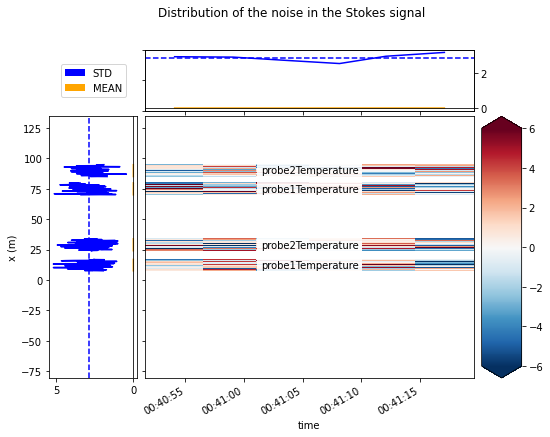

In [5]:
from dtscalibration import plot

fig_handle = plot.plot_residuals_reference_sections(
        residuals,
        sections,
        title='Distribution of the noise in the Stokes signal',
        plot_avg_std=I_var ** 0.5,
        plot_names=True,
        robust=True,
        units='',
        method='single')

The residuals should be normally distributed and independent from previous time steps and other points along the cable. If you observe patterns in the residuals plot (above), it might be caused by:
- The temperature in the calibration bath is not uniform
- Attenuation caused by coils/sharp bends in cable
- Attenuation caused by a splice

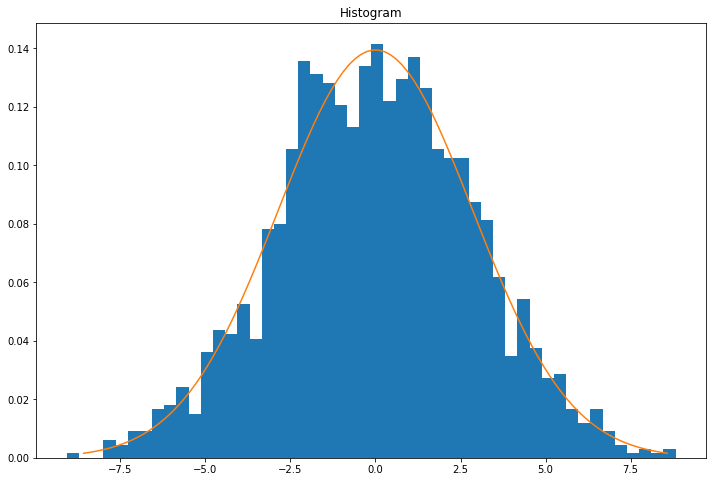

In [6]:
import scipy
import numpy as np

sigma = residuals.std()
mean = residuals.mean()
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
approximated_normal_fit = scipy.stats.norm.pdf(x, mean, sigma)
residuals.plot.hist(bins=50, figsize=(12, 8), density=True)
plt.plot(x, approximated_normal_fit);

We can follow the same steps to calculate the variance from the noise in the anti-Stokes measurments by setting `st_label='ast` and redoing the steps.